In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/Chemistry_PhD/MIE_atlas/')

# custom import from MIE_atlas library
from featurizers.molfeaturizer import MorganFPFeaturizer

import pandas as pd
import numpy as np


!pip install rdkit-pypi -qqq
!pip install pubchempy


import pubchempy as pcp
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.SaltRemover import SaltRemover


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Original workflow!!

root_path = '/content/drive/MyDrive/Chemistry_PhD/interpretability/data'

helma_path = root_path + '/helma_data.csv'
martinez_path = root_path + '/martinez_data.csv'
xu_path = root_path + '/xu_data.csv'

helma_raw = pd.read_csv(helma_path) # 8309 entries
martinez_raw = pd.read_csv(martinez_path) #5536 entries
xu_raw = pd.read_csv(xu_path) # 8348 entries



# drop inconclusive labels from Martinez dataset (231 entries)
martinez_raw = martinez_raw[martinez_raw['Overall'] != 0][['SMILES RDKit', 'Overall']] # remaining 5305 entries
# set label to 1 if active, else 0 (originally 1 if active else -1 since 0 was taken by inconclusive)
martinez_raw['Label'] = [1 if x == 1 else 0 for x in martinez_raw['Overall']]
martinez_raw.drop(columns = ['Overall'], inplace = True)

helma_raw.columns = ['SMILES', 'Label']
xu_raw.columns = ['SMILES', 'Label']
martinez_raw.columns = ['SMILES', 'Label']

'''
Helma and Martinez SMILES all successfully processed by RDKit. 

Xu SMILES contains 341 molecules that can't be ready by RDKit. Run them through PubChemPy to get canonicalized SMILES. 
Remaining 9 can't be read by PubChemPy: 

{7245: 'C/N(/O)=N/CC1OC(CO)C(O)C(O)C1O',
 7380: 'N1(=CC=CC(=C1)C(=O)O)(C)Cl',
 7388: 'ClCCC[N](Cl)(C)C',
 7408: 'CN(C)(C)(Cc1ccccc1)Cl',
 7502: 'n1c(N(Cc2ccc(OC)cc2)CC[N](Cl)(C)C)nccc1',
 7513: 'C[N](Cl)(C)C1C(O)C(C(=O)N)C(=O)C2(O)C1CC1C(=C2O)C(=O)c2c(O)cccc2C1(C)O',
 7521: 'C[N](Cl)(C)c1ccc2cc3ccc(cc3nc2c1)N(C)C',
 8130: 'CN1C[N]C2=C1N=C=N(=C2N)O',
 8232: 'CC(O)CN(=[NH+]C(=O)C(=C)C)(C)C'}


7245: manually found 'C[N+](=NCC1C(C(C(C(O1)CO)O)O)O)[O-]'
the rest were manually inspected and found to be malformed SMILES that don't correspond to real chemicals (4 valent N bonded to Cl, 5 valent N and 6 valent C)
'''

xu_map = dict([(idx, smi) for idx, smi in enumerate(xu_raw['SMILES']) if not Chem.MolFromSmiles(smi)])
pcp_found = dict()
for idx, smiles in xu_map.items(): 
    try: 
        pubchem_found = pcp.get_properties('IsomericSMILES', smiles, 'smiles')[0]['IsomericSMILES']
        pcp_found[idx] = pubchem_found
    except: 
        pcp_found[idx] = None

# update SMILES
for idx, smi in pcp_found.items(): 
    xu_raw.at[idx, 'SMILES'] = smi
# One manual entry
xu_raw.at[7245, 'SMILES'] = 'C[N+](=NCC1C(C(C(C(O1)CO)O)O)O)[O-]'
# drop None SMILES
xu_raw.dropna(inplace = True) # remaining 8340 molecules



# combine datasets
combined_raw = pd.concat([helma_raw, martinez_raw, xu_raw], ignore_index = True) # 21954 entries


molecules = [Chem.MolFromSmiles(x, sanitize = True) for x in combined_raw['SMILES']]
remover = SaltRemover()
no_stereo_blank = [Chem.RemoveStereochemistry(x) for x in molecules] # removes inplace, this is just a placeholder to store the None
no_salts = [remover.StripMol(x, dontRemoveEverything = True) for x in molecules]

clean_smiles = [Chem.MolToSmiles(x, isomericSmiles = False, canonical = True) for x in no_salts]
clean_inchis = [Chem.MolToInchi(x) for x in no_salts]

combined_raw['Clean SMILES'] = clean_smiles
combined_raw['Clean InChIs'] = clean_inchis


def remove_dupes(rawdata): 
    # takes in a dataframe consisting of cleaned canonical SMILES and InChIs from the previous step and removes duplicated molecules 

    rawdata.sort_values(by=['Clean SMILES', 'Clean InChIs', 'Label'], ascending = True, inplace = True, ignore_index = True)
    rawdata.drop_duplicates(subset = ['Clean SMILES'], keep = 'last', inplace = True, ignore_index = True)
    rawdata.drop_duplicates(subset = ['Clean InChIs'], keep = 'last', inplace = True, ignore_index = True)


    rawdata.drop(columns = ['SMILES'], inplace = True)

    rawdata.columns = ['Label', 'SMILES', 'InChIs']

    return rawdata

combined_cleaned = remove_dupes(combined_raw)

combined_cleaned.to_csv(root_path + '/combined_cleaned_data.csv', index = False) # 8403 entries, 4265 positives and 4138 negatives

In [ ]:
# One stop function. Entries must have column names ['SMILES', 'Label']! 

def clean_data(rawdata): 
    # takes in raw dataframe of data consisting of 2 columns = ['SMILES', 'Label'] and outputs cleaned data
    # cleaning implies a) checking for valid SMILES strings, b) removing stereochemistry, c) removing salts

    # first check if RDKit can process the SMILES. 
    rdkit_failed = dict([(idx, smi) for idx, smi in enumerate(rawdata['SMILES']) if not Chem.MolFromSmiles(smi)])
    # if not, check on PubChem for valid molecules. 
    pcp_found = dict()
    for idx, smiles in rdkit_failed.items(): 
        try: 
            pubchem_found = pcp.get_properties('IsomericSMILES', smiles, 'smiles')[0]['IsomericSMILES'] # unique match only
            pcp_found[idx] = pubchem_found
        except: 
            pcp_found[idx] = None

    # update found SMILES
    for idx, smi in pcp_found.items(): 
        rawdata.at[idx, 'SMILES'] = smi
    # drop None SMILES
    rawdata.dropna(inplace = True)

    # Now all mols should be RDKit readable
    # RDKit mol processing --> read mols, remove stereochem (including cis/trans alkenes!) and strip salts 
    molecules = [Chem.MolFromSmiles(x, sanitize = True) for x in rawdata['SMILES']]
    remover = SaltRemover()
    no_stereo_blank = [Chem.RemoveStereochemistry(x) for x in molecules] # removes inplace, this is just a placeholder to store the None
    no_salts = [remover.StripMol(x, dontRemoveEverything = True) for x in molecules]

    clean_smiles = [Chem.MolToSmiles(x, isomericSmiles = False, canonical = True) for x in no_salts]
    clean_inchis = [Chem.MolToInchi(x) for x in no_salts]

    # write clean SMILES and InChIs for later processing
    rawdata['Clean SMILES'] = clean_smiles
    rawdata['Clean InChIs'] = clean_inchis
    rawdata.drop(columns = ['SMILES'], inplace = True)

    # sort entries by SMILES and InChIs, keeping last entry ensures label of 1 supercedes label of 0
    rawdata.sort_values(by=['Clean SMILES', 'Clean InChIs', 'Label'], ascending = True, inplace = True, ignore_index = True)
    # drop duplicated values in either SMILES or InChIs column, keeping label of 1 where possible
    rawdata.drop_duplicates(subset = ['Clean SMILES'], keep = 'last', inplace = True, ignore_index = True)
    rawdata.drop_duplicates(subset = ['Clean InChIs'], keep = 'last', inplace = True, ignore_index = True)

    rawdata.columns = ['Label', 'SMILES', 'InChIs']

    return rawdata


root_path = '/content/drive/MyDrive/Chemistry_PhD/interpretability/data'

helma_path = root_path + '/helma_data.csv'
martinez_path = root_path + '/martinez_data.csv'
xu_path = root_path + '/xu_data.csv'

helma_raw = pd.read_csv(helma_path) # 8309 entries
martinez_raw = pd.read_csv(martinez_path) #5536 entries
xu_raw = pd.read_csv(xu_path) # 8348 entries



# drop inconclusive labels from Martinez dataset (231 entries)
martinez_raw = martinez_raw[martinez_raw['Overall'] != 0][['SMILES RDKit', 'Overall']] # remaining 5305 entries
# set label to 1 if active, else 0 (originally 1 if active else -1 since 0 was taken by inconclusive)
martinez_raw['Label'] = [1 if x == 1 else 0 for x in martinez_raw['Overall']]
martinez_raw.drop(columns = ['Overall'], inplace = True)

helma_raw.columns = ['SMILES', 'Label']
xu_raw.columns = ['SMILES', 'Label']
martinez_raw.columns = ['SMILES', 'Label']

xu_cleaned = clean_data(xu_raw)
martinez_cleaned = clean_data(martinez_raw)
helma_cleaned = clean_data(helma_raw)

xu_cleaned.to_csv(root_path + '/xu_cleaned_data.csv', index = False) # 6765 entries, 3668 positive and 3097 negative
martinez_cleaned.to_csv(root_path + '/martinez_cleaned_data.csv', index = False) # 5194 entries, 3015 positive and 2179 negative
helma_cleaned.to_csv(root_path + '/helma_cleaned_data.csv', index = False) # 7369 entries, 3664 positive and 3705 negative




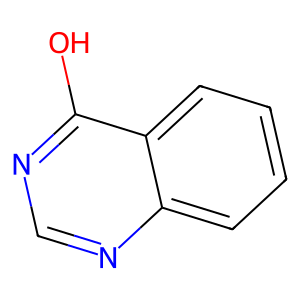

In [ ]:
Draw.MolToImage(Chem.MolFromSmiles('Oc1ncnc2ccccc12', sanitize=True))

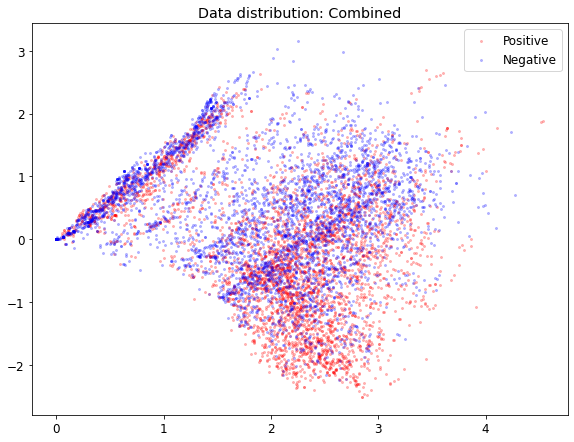

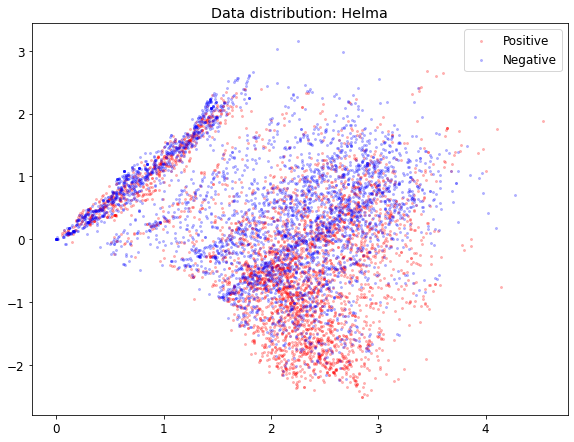

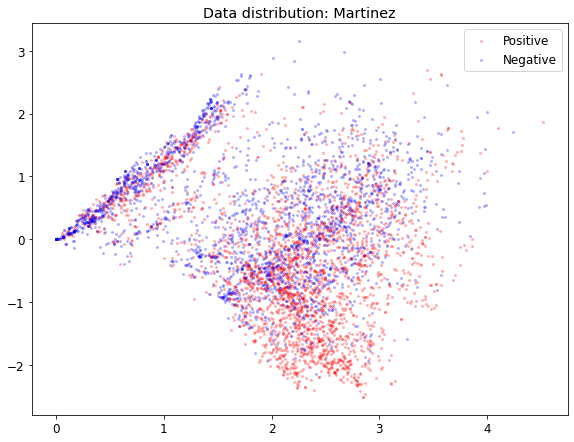

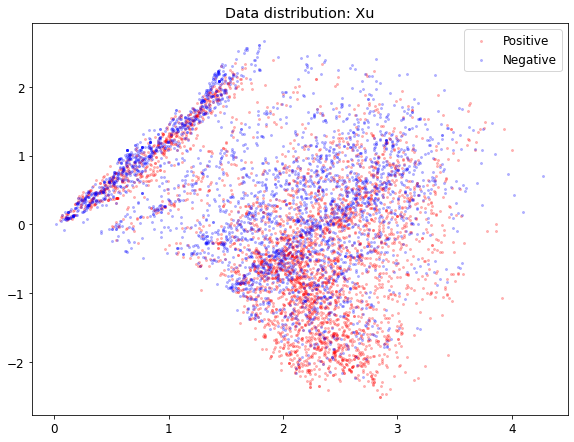

In [ ]:
# Data visualization

from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

featurizer = MorganFPFeaturizer(radius = 2, nBits = 8000)
tsvd = TruncatedSVD(n_components = 2)

all_smiles = combined_cleaned['SMILES']
all_feats = featurizer.transform(all_smiles)
tsvd.fit(all_feats)

def data_visualization(dataset, featurizer, reducer, title, allspace = True): 
    # dataset: array-like, contains binary classification labels under 'Label' column and SMILES as input under 'SMILES' column. 
    # featurizer: object with transform method that converts SMILES input into features for further analysis
    # reducer: dimension reduction for visualization. Recommend: PCA for dense features and TSVD for sparse features. TSNE can be used on lower dimension data. 
    # title: name of the dataset (for plot only)
    # allspace: if True, use featurizer trained on all data (have to include custom trained method for dimension reduction). 

    smiles = dataset['SMILES']
    feats = featurizer.transform(smiles)

    if not allspace: 
        reducer.fit(feats)
    
    reduced_feats = reducer.transform(feats)
    positives = [idx for idx, label in dataset['Label'].items() if label == 1]
    negatives = [idx for idx, label in dataset['Label'].items() if label == 0]

    plt.figure(figsize = [9.6, 7.2])
    plt.scatter(reduced_feats[positives, 0], reduced_feats[positives, 1], color = 'red', alpha = 0.3, lw = 0.5, s = 5, label = 'Positive')
    plt.scatter(reduced_feats[negatives, 0], reduced_feats[negatives, 1], color = 'blue', alpha = 0.3, lw = 0.5, s = 5, label = 'Negative')

    plt.legend(loc = 'best')
    plt.title(f'Data distribution: {title}')

    plt.savefig(f'/content/drive/MyDrive/Chemistry_PhD/interpretability/data/data_visualization/{title}_visualized.png')
    plt.show()

    return 

data_visualization(combined_cleaned, featurizer, tsvd, 'Combined', allspace = True)
data_visualization(helma_cleaned, featurizer, tsvd, 'Helma', allspace = True)
data_visualization(martinez_cleaned, featurizer, tsvd, 'Martinez', allspace = True)
data_visualization(xu_cleaned, featurizer, tsvd, 'Xu', allspace = True)

